# Random Forest 

In [139]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import validation_curve
from sklearn.feature_selection import RFECV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

X_train = train.drop(columns='died')
X_test = test.drop(columns='died')
y_train = train.died
y_test = test.died

# Train baseline random forest model with default parameters

In [4]:
rf_base = RandomForestClassifier(random_state=670).fit(X_train, y_train)
train_auc = roc_auc_score(y_train, rf_base.predict_proba(X_train)[:, 1])
test_auc = roc_auc_score(y_test, rf_base.predict_proba(X_test)[:, 1])
print(round(train_auc, 3))
print(round(test_auc, 3))

1.0
0.834


In [44]:
# Set up k-fold validation set
k_folds = KFold(n_splits=5, shuffle=True, random_state=670)
splits = list(k_folds.split(X_train, y_train))

# Use Grid Search CV to tune hyperparameters
rf_mod = RandomForestClassifier(random_state=2022)
param_grid = {'n_estimators': range(100, 500, 50),
              'max_depth': [2, 3, 4, 5],
              'class_weight':['balanced', 'balanced_subsample']
             }
grid_search = GridSearchCV(rf_mod, 
                           param_grid=param_grid, 
                           cv=splits, 
                           scoring='roc_auc',
                           )
grid_search.fit(X_train, y_train)

# Get best parameters from Grid Search
print(grid_search.best_params_)

train_auc = grid_search.score(X_train, y_train)
test_auc = grid_search.score(X_test, y_test)

print(round(train_auc, 3))
print(round(test_auc, 3))

{'class_weight': 'balanced_subsample', 'max_depth': 5, 'n_estimators': 350}
0.854
0.828


In [130]:
def plot_validation_curves(model, param_range, data, target, param_name, 
                           scoring, cv, ylabel):
    
    train_scores, valid_scores = validation_curve(model, 
                                                  data, 
                                                  target, 
                                                  param_name=param_name, 
                                                  param_range=param_range,
                                                  scoring=scoring,
                                                  cv=cv)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    valid_scores_mean = np.mean(valid_scores, axis=1)
    valid_scores_std = np.std(valid_scores, axis=1)
    
    plt.title(f'Validation Curve with {param_name}')
    plt.xlabel(f'{param_name}')
    plt.ylabel(ylabel)
    plt.ylim(0.0, 1.1)
    lw = 2
    plt.plot(
        param_range, 
        train_scores_mean, 
        label="Training score", 
        color="darkorange", 
        lw=lw
    )
    plt.fill_between(
        param_range,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.2,
        color="darkorange",
        lw=lw,
    )
    plt.plot(
        param_range, 
        valid_scores_mean, 
        label="Cross-validation score", 
        color="navy", 
        lw=lw
    )
    plt.fill_between(
        param_range,
        valid_scores_mean - valid_scores_std,
        valid_scores_mean + valid_scores_std,
        alpha=0.2,
        color="navy",
        lw=lw,
    )
    plt.legend(loc="best")
    plt.show()

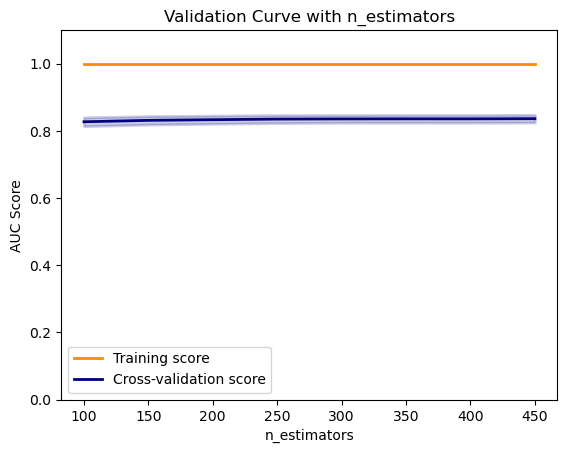

In [131]:
# Plot grid search CV results for n_estimators
plot_validation_curves(model=rf_mod, 
                       param_range=range(100, 500, 50), 
                       data=X_train, 
                       target=y_train, 
                       param_name='n_estimators', 
                       scoring='roc_auc', 
                       cv=splits, 
                       ylabel='AUC Score')

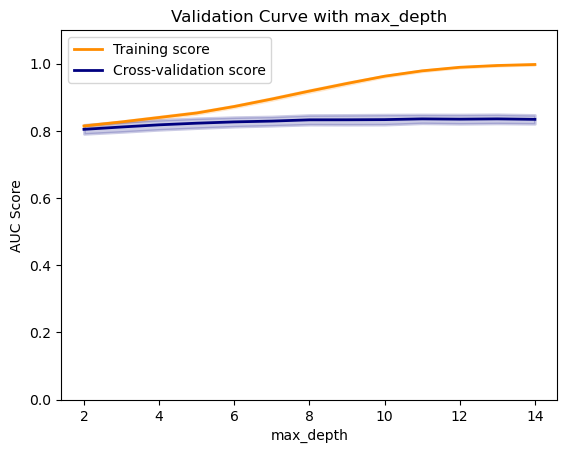

In [132]:
# Plot grid search CV results for max depth
plot_validation_curves(model=rf_mod, 
                       param_range=range(2, 15, 1), 
                       data=X_train, 
                       target=y_train, 
                       param_name='max_depth', 
                       scoring='roc_auc', 
                       cv=splits, 
                       ylabel='AUC Score')

### Train Random Forest with features selected by LASSO

In [135]:
lasso_features = ['admissionheight', 'admissionweight', 'dischargeweight' ,
                  'icuduration', 'weightdiffafterdischarge', 'intubated', 
                  'vent', 'dialysis', 'urine', 'wbc', 'temperature',
                  'respiratoryrate', 'sodium', 'heartrate', 'meanbp', 
                  'creatinine', 'glucose', 'bun', 'meanapachescore',
                  'meanpredictedicumortality', 'meanpredictediculos',
                  'immunosuppression', 'diabetes', 'teachingstatus', 
                  'minnoninvasivesystolic', 'meannoninvasivesystolic', 
                  'maxnoninvasivesystolic', 'minnoninvasivediastolic', 
                  'meannoninvasivediastolic', 'maxnoninvasivediastolic', 
                  'noninvasivemeanmin', 'noninvasivemeanavg', 
                  'noninvasivemeanmax', 'age0-9', 'age10-19', 'age20-29',
                  'age30-39', 'age40-49', 'age50-59', 'age60-69', 'age>89', 
                  'gendermale', 'ethnicity_African American', 'ethnicity_Asian',
                  'ethnicity_Caucasian', 'ethnicity_Hispanic', 
                  'ethnicity_Native American', 'ethnicity_Other/Unknown',
                  'hospitaladmitsource_Acute Care/Floor', 
                  'hospitaladmitsource_Chest Pain Center', 
                  'hospitaladmitsource_Direct Admit', 
                  'hospitaladmitsource_Emergency Department', 
                  'hospitaladmitsource_Floor', 'hospitaladmitsource_ICU', 
                  'hospitaladmitsource_ICU to SDU', 
                  'hospitaladmitsource_Observation', 
                  'hospitaladmitsource_Operating Room', 
                  'hospitaladmitsource_Other Hospital', 
                  'hospitaladmitsource_Other ICU', 
                  'hospitaladmitsource_Step-Down Unit (SDU)', 
                  'unittype_CCU-CTICU', 'unittype_CSICU', 'unittype_CTICU', 
                  'unittype_Cardiac ICU', 'unittype_MICU', 
                  'unittype_Med-Surg ICU', 'unittype_Neuro ICU', 
                  'unitadmitsource_Acute Care/Floor', 
                  'unitadmitsource_Chest Pain Center', 
                  'unitadmitsource_Direct Admit', 
                  'unitadmitsource_Emergency Department', 
                  'unitadmitsource_Floor', 'unitadmitsource_ICU',
                  'unitadmitsource_ICU to SDU', 'unitadmitsource_Observation',
                  'unitadmitsource_Operating Room', 
                  'unitadmitsource_Other Hospital', 'unitadmitsource_Other ICU',
                  'unitadmitsource_PACU', 'unitadmitsource_Recovery Room', 
                  'unitadmitsource_Step-Down Unit (SDU)', 
                  'numbedscategory_100 - 249', 'numbedscategory_250 - 499',
                  'numbedscategory_<100', 'numbedscategory_>= 500', 
                  'hospitalregion_Midwest', 'hospitalregion_South', 
                  'dischargehour8-14']

In [136]:
X_train_lasso = X_train.loc[:, lasso_features]
X_test_lasso = X_test.loc[:, lasso_features]

grid_search_lasso = GridSearchCV(rf_mod, 
                                 param_grid=param_grid, 
                                 cv=splits, 
                                 scoring='roc_auc'
                                )
grid_search_lasso.fit(X_train_lasso, y_train)

# Get best parameters from Grid Search
print(grid_search_lasso.best_params_)

train_auc = grid_search_lasso.score(X_train_lasso, y_train)
test_auc = grid_search_lasso.score(X_test_lasso, y_test)

print(round(train_auc, 3))
print(round(test_auc, 3))

{'max_depth': 5, 'n_estimators': 300}
0.849
0.828


### Train Random Forest with features selected by RFE

In [117]:
rfecv = RFECV(
    estimator=RandomForestClassifier(random_state=670),
    min_features_to_select=10,
    n_jobs=-1,
    scoring="roc_auc",
    cv=splits
)

_ = rfecv.fit(X_train, y_train)
rfe_features = X_train.columns[rfecv.support_]
print(rfe_features)

Index(['admissionheight', 'admissionweight', 'dischargeweight', 'icuduration',
       'weightdiffafterdischarge', 'intubated', 'vent', 'urine', 'wbc',
       'temperature', 'respiratoryrate', 'sodium', 'heartrate', 'meanbp',
       'creatinine', 'glucose', 'bun', 'meanapachescore',
       'meanpredictedicumortality', 'meanpredictediculos', 'immunosuppression',
       'diabetes', 'teachingstatus', 'minnoninvasivesystolic',
       'meannoninvasivesystolic', 'maxnoninvasivesystolic',
       'minnoninvasivediastolic', 'meannoninvasivediastolic',
       'maxnoninvasivediastolic', 'noninvasivemeanmin', 'noninvasivemeanavg',
       'noninvasivemeanmax', 'age50-59', 'age60-69', 'age>89', 'gendermale',
       'ethnicity_African American', 'ethnicity_Caucasian',
       'ethnicity_Hispanic', 'ethnicity_Other/Unknown',
       'hospitaladmitsource_Direct Admit',
       'hospitaladmitsource_Emergency Department', 'hospitaladmitsource_Floor',
       'hospitaladmitsource_Step-Down Unit (SDU)', 'unitty

In [121]:
X_train_rfe = X_train.loc[:, rfe_features]
X_test_rfe = X_test.loc[:, rfe_features]

grid_search_rfe = GridSearchCV(rf_mod, 
                               param_grid=param_grid, 
                               cv=splits, 
                               scoring='roc_auc'
                              )
grid_search_rfe.fit(X_train_rfe, y_train)

# Get best parameters from Grid Search
print(grid_search_rfe.best_params_)

train_auc = grid_search_rfe.score(X_train_rfe, y_train)
test_auc = grid_search_rfe.score(X_test_rfe, y_test)

print(round(train_auc, 3))
print(round(test_auc, 3))

{'max_depth': 5, 'n_estimators': 400}
0.85
0.828


### Train Random Forest with features selected by Boruta

In [122]:
boruta_features = ['admissionweight', 'dischargeweight', 'icuduration', 
                   'weightdiffafterdischarge', 'intubated', 'vent', 'urine', 
                   'wbc', 'temperature', 'respiratoryrate', 'sodium', 
                   'heartrate', 'meanbp', 'creatinine', 'bun', 
                   'meanapachescore', 'meanpredictedicumortality', 
                   'meanpredictediculos', 'minnoninvasivesystolic', 
                   'meannoninvasivesystolic', 'maxnoninvasivesystolic', 
                   'minnoninvasivediastolic', 'meannoninvasivediastolic', 
                   'maxnoninvasivediastolic', 'noninvasivemeanmin', 
                   'noninvasivemeanavg', 'noninvasivemeanmax', 
                   'hospitaladmitsource_Floor', 'unitadmitsource_Floor', 
                   'unitadmitsource_Operating Room']

In [124]:
X_train_boruta = X_train.loc[:, boruta_features]
X_test_boruta = X_test.loc[:, boruta_features]

grid_search_boruta = GridSearchCV(rf_mod, 
                                  param_grid=param_grid, 
                                  cv=splits, 
                                  scoring='roc_auc'
                                 )
grid_search_boruta.fit(X_train_boruta, y_train)

# Get best parameters from Grid Search
print(grid_search_boruta.best_params_)

train_auc = grid_search_boruta.score(X_train_boruta, y_train)
test_auc = grid_search_boruta.score(X_test_boruta, y_test)

print(round(train_auc, 3))
print(round(test_auc, 3))

{'max_depth': 5, 'n_estimators': 200}
0.848
0.827


### Evaluate final model 

In [133]:
def calculate_youden_index_cutoff(y_true, y_pred):
    
    # Calculate probability cut-off that maximizes the Youden index
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    idx = np.argmax(tpr - fpr)
    return thresholds[idx]

In [140]:
train_pred_probs = grid_search_lasso.predict_proba(X_train_lasso)[:, 1]
test_pred_probs = grid_search_lasso.predict_proba(X_test_lasso)[:, 1]

train_cutoff = calculate_youden_index_cutoff(y_train, train_pred_probs)
test_cutoff = calculate_youden_index_cutoff(y_test, test_pred_probs)
y_pred_train = np.where(train_pred_probs > train_cutoff, 1, 0)
y_pred_test = np.where(test_pred_probs > test_cutoff, 1, 0)

train_precision = precision_score(y_train, y_pred_train)
test_precision = precision_score(y_test, y_pred_test)

train_recall = recall_score(y_train, y_pred_train)
test_recall = recall_score(y_test, y_pred_test)

print(f'Train Precision: {train_precision}')
print(f'Test Precision: {test_precision}')
print(f'Train Recall: {train_recall}')
print(f'Test Recall: {test_recall}')

Train Precision: 0.3023996082272282
Test Precision: 0.2902930402930403
Train Recall: 0.7816455696202531
Test Recall: 0.782716049382716
